In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score
from sklearn.utils import resample
#from sklearn.linear_model import SGDClassifier , LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import ensemble
#from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
#from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from helper import get_confusion_matrix, model_results

plt.style.use('ggplot')

pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv("train_sampled.csv", index_col=0)

## Preparing the data for Bagging & Boosting

In [3]:
le =LabelEncoder()
serviceType =le.fit_transform(train_data['ServiceType'])

train_nonlinear= train_data.copy()
train_nonlinear['ServiceType'] = serviceType

features = train_nonlinear.drop(['Provider', 'PotentialFraud', 'INDEX'], axis=1)
target= train_nonlinear['PotentialFraud']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

In [6]:
LGB = lgb.LGBMClassifier()


np.random.seed(5)
lgb_para = [{
    "n_estimators": [300,400,500],
    "max_depth": [12,13,14,15],
    "learning_rate": np.linspace(1e-2,1,20),
    "colsample_bytree" : [0.5,0.7,1,1.2],
    "subsample": [0.6,0.8,1,1.2],
    "num_leaves" : [100,125,150,175]
}]

grid_lgb = RandomizedSearchCV(LGB, lgb_para, scoring ='accuracy',cv=5)

In [7]:
grid_lgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(),
                   param_distributions=[{'colsample_bytree': [0.5, 0.7, 1, 1.2],
                                         'learning_rate': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ]),
                                         'max_depth': [12, 13, 14, 15],
                                         'n_estimators': [300, 400, 500],
                                         'num_leaves': [100, 125, 150, 175],
                                         'subsample': [0.6, 0.8, 1, 1.2]}],
                   scoring='accuracy')

In [8]:
print(grid_lgb.best_params_)
print(grid_lgb.best_score_)

{'subsample': 0.6, 'num_leaves': 100, 'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.4268421052631579, 'colsample_bytree': 0.7}
0.9813923428854437


In [9]:
model_results(X_train, y_train, X_test, y_test, grid_lgb, show=True)

The Model Results for  RandomizedSearchCV(cv=5, estimator=LGBMClassifier(),
                   param_distributions=[{'colsample_bytree': [0.5, 0.7, 1, 1.2],
                                         'learning_rate': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ]),
                                         'max_depth': [12, 13, 14, 15],
                                         'n_estimators': [300, 400, 500],
                                         'num_leaves': [100, 125, 150, 175],
                                         'subsample': [0.6, 0.8, 1, 1.2]}],
                   scoring='accuracy')
************************************************************
Train Accuracy is equal to 1.000
Test Accuracy is equal to 0.984
The Precision score is 0.968
The Average Precision 

[1.0, 0.9836901121304791, 0.9684106614017769, 1.0]

Text(0, 0.5, 'Features')

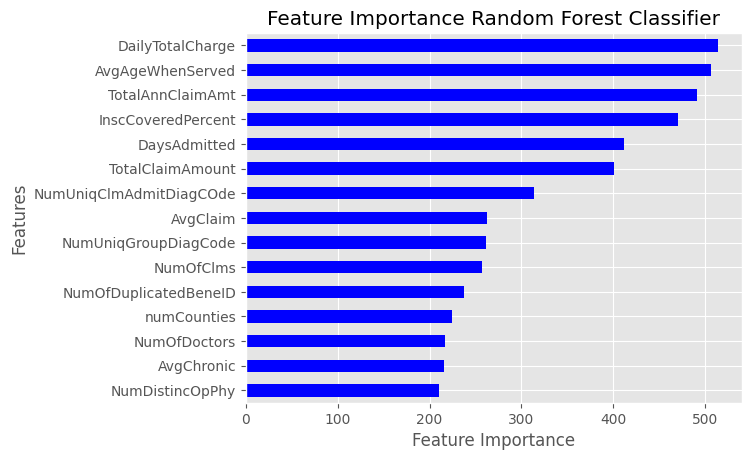

In [11]:
#Feature importance
sorted_importance = sorted(zip(features.columns, grid_lgb.best_estimator_.feature_importances_), key=lambda t:t[1], reverse=True)[:15]
sorted_importance.sort(key= lambda t : t[1])

a, b = zip(*sorted_importance) # this splits the list of tuples into two lists

pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.barh(x='feature_name',
                                                                 y='importance_score', 
                                                                 color='blue',
                                                                 legend=None)
plt.title('Feature Importance Random Forest Classifier')
plt.xlabel("Feature Importance")
plt.ylabel("Features")